# Data Science applied to CEDAE data

CEDAE is the coorporation that provides drinking water and wastewater services for the Rio de Janeiro State.
They provide plenty of data regarding the quality of the water for the press and for the population, due to laws imposed by the Ministry of Health of Brazil.

There are data for physical, chemical and biological parameters of the drinking water of all ETAs (Estações de Tratamento de Água, or _Water Treatment Stations_).
Amongst the ETAs managed by CEDAE is the Guandu, the largest ETA of the world, which provides drinking water for the municipalities of Nilópolis, Nova Iguaçu, Duque de Caxias, Belford Roxo, São João de Meriti, Itaguaí, Queimados and Rio de Janeiro.

First, we need to download the HTML page with the links to the PDFs.

In [1]:
import urllib.request

with urllib.request.urlopen('https://cedae.com.br/relatoriosguandu') as fp:
    HTML_page = fp.read().decode() # Read from page and decode to UTF-8 string

Then we define an `HTMLParser` class for scrapping hyperlinks.

In [2]:
import html.parser

class HyperlinkScraper(html.parser.HTMLParser):
    
    def __init__(self, predicate):
        super().__init__()
        self.link = None
        self.links = dict()
        self.year = None
        self.in_h2 = False
        self.pred = predicate

    def handle_starttag(self, tag, attrs):
        if tag == 'a':
            # Replace spaces with %20
            self.link = {value.replace(' ', '%20')
                         for name, value in attrs
                         if name == 'href'}
        elif tag == 'h2':
            self.in_h2 = True

    def handle_data(self, data):
        if self.in_h2:
            # When in h2, search for a year
            for word in data.split():
                if word.isdigit():
                    number = int(word)
                    # CEDAE was created in 1975
                    # 2100 seems a good upper bound here
                    if 1975 <= number <= 2100:
                        self.year = number
                        break
        if self.link and self.year and self.pred(data):
            # If inside an <a> tag, and any link was found,
            # and an year was found and the predicate is true,
            # then add the links to the set of links of that year
            if self.year not in self.links:
                self.links[self.year] = set()
            self.links[self.year] |= self.link

    def handle_endtag(self, tag):
        if tag == 'a':
            self.link = None
        elif tag == 'h2':
            self.in_h2 = False

We then feed the parser with the HTML page contents and get the scrapped links. We are first interested in data relating to geosmin.

In [3]:
def geosmin_predicate(data):
    return 'GEOSMINA' in data.upper()

scraper = HyperlinkScraper(geosmin_predicate)
scraper.feed(HTML_page)

Finally, we download the PDFs and convert them to pandas DataFrames.

In [4]:
import urllib.parse
import tabula

dfs = {}
for year, links in scraper.links.items():
    assert len(links) == 1, "Assumed there is 1 report per year"
    link = next(iter(links))
    with urllib.request.urlopen(link) as fp:
        dfs[year] = tabula.read_pdf(fp,
                                    pages='all',
                                    silent=True)

If you were to look at the PDFs in the `data` directory, you'd see that the tables have a merged cell in the header with the text "CONCENTRAÇÃO TOTAL - GEOSMINA / MIB". Tabula simply assumes this is indeed a column. The consequence is that the subcolumns are all crammed together.

In [5]:
dfs[2021][0][:10]

,Unnamed: 0,CONCENTRAÇÃO TOTAL - GEOSMINA / MIB
0,NaN,Análises Terceirizadas - Laboratório Mérieux N...
1,DATA DE COLETA,NaN
2,NaN,Saída de Tratamento Saída de Tratamento
3,NaN,Ponto de Captação
4,NaN,VETA NETA
5,NaN,(mg/L)
6,NaN,(mg/L) (mg/L)
7,01/01/2021,"<0,010 <0,010 <0,010"
8,02/01/2021,"<0,010 <0,010 <0,010"
9,03/01/2021,"<0,010 <0,010 <0,010"


One important discontinuity in the data is that before 18/03/2020, the concentration of geosmin and MIB of both ETAs (new and old, VETA and NETA) were averaged. After these date, these concentrations were measured and exposed separetely, since they are independent.

A solution to this problem is to create four time series: before capture, VETA, NETA and the medium between VETA and NETA. For measurements later than 18/03/2020, calculating the weighted mean of the VETA and NETA values requires a missing data: the flow rate of each ETA.

Also, we remove the header of these tables.

In [6]:
from datetime import datetime

date_format = '%d/%m/%Y'

# Find the first row where the the value in the first
# column (date) is a valid date in the format above
# and remove any rows before it
for df_list in dfs.values():
    for df_idx, df in enumerate(df_list):
        assert len(df.columns) == 2, "Assumed data frames have 2 columns initially"
        df.columns = ['date', 'params']
        for row_idx, row in df.iterrows():
            try:
                date = datetime.strptime(str(row.date), date_format)
            except ValueError:
                pass
            else:
                df_list[df_idx] = df[row_idx:]
                break

dfs[2021][2][:10]

,date,params
7,28/03/2021,"0,077 0,092 0,020"
8,29/03/2021,"0,521 0,170 0,045"
9,30/03/2021,"0,495 0,109 0,018"
10,31/03/2021,"0,732 0,261 0,049"
11,01/04/2021,"0,726 0,194 0,052"
12,02/04/2021,"1,551 0,088 0,066"
13,03/04/2021,"1,166 0,516 0,080"
14,04/04/2021,"1,905 0,493 0,088"
15,05/04/2021,"0,537 0,308 0,075"
16,06/04/2021,"0,641 0,152 0,033"


Then, we split the "params" column into "capture", "veta" and "neta" for measurements after 18/03/2020, and into "capture", "etas" before this date.

In [7]:
for year, df_list in dfs.items():
    for df_index, df in enumerate(df_list):
        
        if year == 2020 and df_index == 0:
            columns = ['capture', 'etas']
        else:
            columns = ['capture', 'veta', 'neta']
        
        df[columns] = df['params'].str.split(n=len(columns)-1, expand=True)
        del df['params']

dfs[2021][1][:10]

,date,capture,veta,neta
7,13/02/2021,"<0,010","<0,010","<0,010"
8,14/02/2021,"<0,010","<0,010","<0,010"
9,15/02/2021,"<0,010","<0,010","<0,010"
10,16/02/2021,"<0,010","<0,010","<0,010"
11,17/02/2021,"<0,010","<0,010","<0,010"
12,18/02/2021,"<0,010","<0,010","<0,010"
13,19/02/2021,"<0,010","<0,010","<0,010"
14,20/02/2021,"<0,010","<0,010","<0,010"
15,21/02/2021,"<0,010","<0,010","<0,010"
16,22/02/2021,"<0,010","<0,010","<0,010"


Now, we convert the strings into numbers and dates.

We see that values lower than 0.010 micrograms per liter are supressed. In order to keep that information, we'll store the value 0, but knowing that it actually represents all values between 0 and 0.010 (exclusive).

In [8]:
import pandas as pd

for year, df_list in dfs.items():
    for df_index, df in enumerate(df_list):
        
        if year == 2020 and df_index == 0:
            columns = ['capture', 'etas']
        else:
            columns = ['capture', 'veta', 'neta']
        
        df.date = pd.to_datetime(df.date, dayfirst=True)
        
        for column in columns:
            df[column] = pd.to_numeric(df[column]
                                      .str.replace(' ', '')                    # any space is removed
                                      .str.replace(',', '.')                   # use . as decimal delimiter
                                      .str.replace('<.*', '0.0', regex=True))  # supress uncertainties

dfs[2021][1][:10]

,date,capture,veta,neta
7,2021-02-13,0.0,0.0,0.0
8,2021-02-14,0.0,0.0,0.0
9,2021-02-15,0.0,0.0,0.0
10,2021-02-16,0.0,0.0,0.0
11,2021-02-17,0.0,0.0,0.0
12,2021-02-18,0.0,0.0,0.0
13,2021-02-19,0.0,0.0,0.0
14,2021-02-20,0.0,0.0,0.0
15,2021-02-21,0.0,0.0,0.0
16,2021-02-22,0.0,0.0,0.0


We then concatenate the data frames with same columns.

In [9]:
df1 = None
df2 = []

for year, df_list in sorted(dfs.items()):
    for df_index, df in enumerate(df_list):
        if year == 2020 and df_index == 0:
            df1 = df
        else:
            df2.append(df)

df2 = pd.concat(df2, ignore_index=True)

Now that the data is nicely formatted, we can plot them with `matplotlib`

In [10]:
import matplotlib.pyplot as plt

First, the data before 18/03/2020.

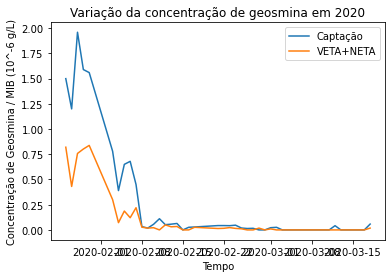

In [11]:
plt.plot(df1.date, df1.capture, label='Captação')
plt.plot(df1.date, df1.etas, label='VETA+NETA')
plt.xlabel('Tempo')
plt.ylabel('Concentração de Geosmina / MIB (10^-6 g/L)')
plt.title('Variação da concentração de geosmina em 2020')
plt.legend()
plt.show()

And then, after this date.

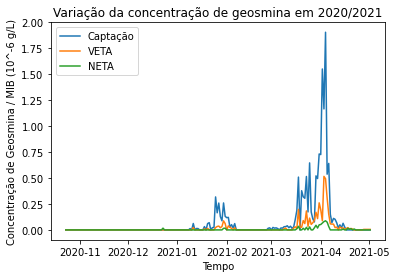

In [12]:
plt.plot(df2.date, df2.capture, label='Captação')
plt.plot(df2.date, df2.veta, label='VETA')
plt.plot(df2.date, df2.neta, label='NETA')
plt.xlabel('Tempo')
plt.ylabel('Concentração de Geosmina / MIB (10^-6 g/L)')
plt.title('Variação da concentração de geosmina em 2020/2021')
plt.legend()
plt.show()

We then export this data in the CSV format.

In [13]:
df1.to_csv('geosmin-2020-01-26_2020-03-18.csv', index=False)
df2.to_csv('geosmin-2020-10-23_today.csv', index=False)